In [1]:
##########################################
# Size Portfolio for CRSP Securities     #
# July 2018                              #                        
# Qingyi (Freda) Song Drechsler          #
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
from dateutil.relativedelta import *

In [2]:
###################
# Connect to WRDS #
###################
conn = wrds.Connection()

WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\declan.mccormack\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [3]:
################################################
# Get CRSP Monthly Stocks for Decile Formation #
################################################
msf = conn.raw_sql("""
                      select a.permno, a.date, 
                      a.ret, a.shrout, a.prc 
                      from crsp.msf as a
                      where a.date >= '12/01/1999'
                      """, date_cols=['date'])

# keep only records with non missing ret prc and shrout value
msf = msf[(msf['prc'].notna()) & (msf['ret'].notna()) & (msf['shrout'].notna())]

msf['permno'] = msf['permno'].astype(int)
msf['size'] = msf['shrout'] * msf['prc'].abs()
msf['year'] = msf['date'].dt.year
msf['month'] = msf['date'].dt.month

# create msf_dec
msf_dec = msf[msf['month']==12][['date','permno','year','size']]

# create msf_ls
msf_ls = msf.sort_values(['permno', 'date'])
msf_ls['year_prev'] = msf_ls['year']-1
msf_ls['size_lag'] = msf_ls.groupby('permno')['size'].shift(1)
msf_ls['size_lag'] = np.where(msf_ls['size_lag'].isna(),\
 msf_ls['size']/(1+msf_ls['ret']), msf_ls['size_lag'])

In [4]:
#################################
# Compute Deciles for Each DEC  #
#################################
msf_dec = msf_dec.sort_values(['year'])
msf_dec['decile']=1+msf_dec.groupby('year')['size']\
.transform(lambda x: pd.qcut(x, 10, labels=False))

In [5]:
###################################
# Assign Size Group to All Months #
###################################
msf_groups = pd.merge(msf_ls[['permno','date','ret','size_lag','year_prev']], \
                      msf_dec[['permno','year','decile']], how='left', \
                      left_on=['permno','year_prev'], right_on=['permno','year'])

msf_groups=msf_groups[msf_groups['decile'].notna()]

In [6]:
#################################
# Compute Size Weighted Returns #
#################################
msf_groups = msf_groups.sort_values(['decile', 'date'])

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

# value-weigthed return
vwrets=msf_groups.groupby(['decile','date']).apply(wavg, 'ret','size_lag')\
.to_frame().reset_index().rename(columns={0: 'vwret'})

C:\Users\declan.mccormack\AppData\Local\Temp\ipykernel_18304\2607878641.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwrets=msf_groups.groupby(['decile','date']).apply(wavg, 'ret','size_lag')\


In [7]:
################################## 
# Compare Results with CRSP MSIX #
##################################
msix = conn.raw_sql("""
                      select caldt, decret1, decret2, decret3, decret4, decret5,
                      decret6, decret7, decret8, decret9, decret10
                      from crsp.msix where caldt >= '12/01/1999'
                      """, date_cols=['caldt']) 

# transpose msix data
msix1=pd.melt(msix, id_vars='caldt', \
              value_vars=['decret1','decret2', 'decret3', 'decret4', 'decret5', 'decret6', \
'decret7', 'decret8','decret9','decret10'])

# extract decile information from decret
msix1['decile'] = msix1['variable'].str[6:].astype(int)
# rename return column
msix1 = msix1.rename(columns={'value':'decret', 'caldt':'date'})
msix1 = msix1.drop(['variable'], axis=1)

decile_returns = pd.merge(vwrets, msix1, how='left', on=['date','decile'])

###################
# End of Program  #
###################

In [8]:
decile_returns.head()

,decile,date,vwret,decret
0,1.0,2000-01-31,0.222623,0.207738
1,1.0,2000-02-29,0.246672,0.240418
2,1.0,2000-03-31,-0.024419,-0.027778
3,1.0,2000-04-28,-0.175907,-0.17039
4,1.0,2000-05-31,-0.093232,-0.087108


In [10]:
####################
# Visualization    #
####################

# Plotting the returns by decile
import os
import matplotlib.pyplot as plt
%matplotlib inline

df = decile_returns
df1 = df[df['decile']==1]
df2 = df[df['decile']==2]
df3 = df[df['decile']==3]
df4 = df[df['decile']==4]
df5 = df[df['decile']==5]
df6 = df[df['decile']==6]
df7 = df[df['decile']==7]
df8 = df[df['decile']==8]
df9 = df[df['decile']==9]
df10 = df[df['decile']==10]

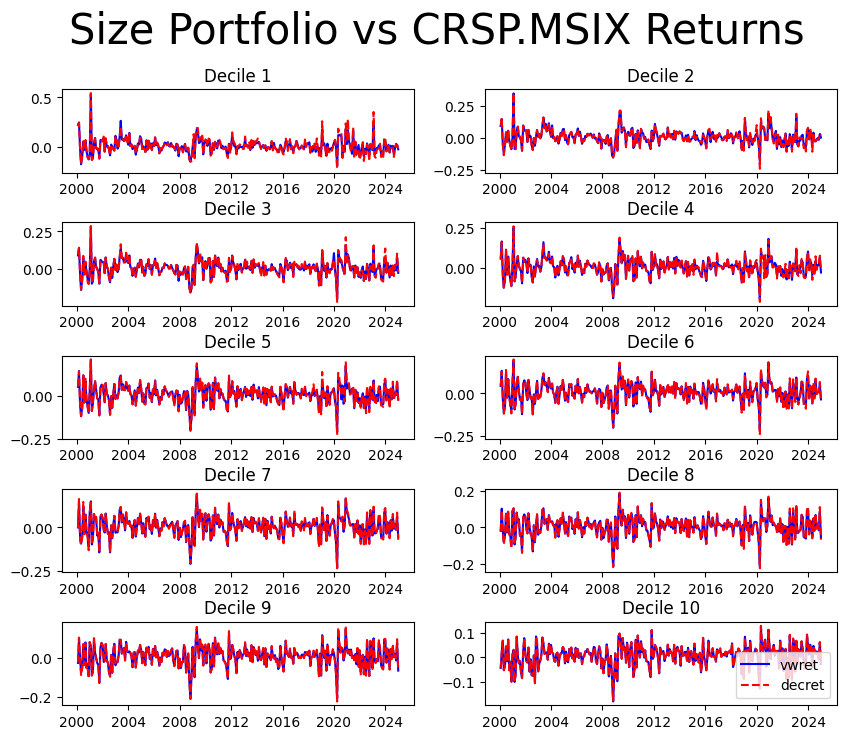

In [11]:
fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(hspace=.6)
plt.suptitle('Size Portfolio vs CRSP.MSIX Returns', fontsize=30)

plt.subplot(521)
plt.plot(df1['date'], df1['vwret'], 'b', df1['date'], df1['decret'], 'r--')
plt.title('Decile 1')

plt.subplot(522)
plt.plot(df2['date'], df2['vwret'], 'b', df2['date'], df2['decret'], 'r--')
plt.title('Decile 2')

plt.subplot(523)
plt.plot(df3['date'], df3['vwret'], 'b', df3['date'], df3['decret'], 'r--')
plt.title('Decile 3')

plt.subplot(524)
plt.plot(df4['date'], df4['vwret'], 'b', df4['date'], df4['decret'], 'r--')
plt.title('Decile 4')

plt.subplot(525)
plt.plot(df5['date'], df5['vwret'], 'b', df5['date'], df5['decret'], 'r--')
plt.title('Decile 5')

plt.subplot(526)
plt.plot(df6['date'], df6['vwret'], 'b', df6['date'], df6['decret'], 'r--')
plt.title('Decile 6')

plt.subplot(527)
plt.plot(df7['date'], df7['vwret'], 'b', df7['date'], df7['decret'], 'r--')
plt.title('Decile 7')

plt.subplot(528)
plt.plot(df8['date'], df8['vwret'], 'b', df8['date'], df8['decret'], 'r--')
plt.title('Decile 8')

plt.subplot(529)
plt.plot(df9['date'], df9['vwret'], 'b', df9['date'], df9['decret'], 'r--')
plt.title('Decile 9')

plt.subplot(5,2,10)
plt.plot(df10['date'], df10['vwret'], 'b', df10['date'], df10['decret'], 'r--')
plt.title('Decile 10')

plt.legend(['vwret', 'decret'])
plt.show()

#uncomment and edit these lines to save the png output
#from pathlib import Path
#fig.savefig(os.path.join(Path.home(), '<your_subdirectory>', 'size_port_return.png'))
